In [21]:
import warnings
warnings.filterwarnings('ignore')
import ast

from selenium import webdriver
from bs4 import BeautifulSoup
import requests, os, sys, json, csv, copy, operator
from collections import Counter

import pandas as pd
import numpy as np
import pickle, time
import seaborn as sns
from scipy.io import savemat, loadmat
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # ???
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import jaccard
from gensim.matutils import jensen_shannon


import pyLDAvis
from pyLDAvis import gensim as pyldagensim
from pyLDAvis import sklearn as pyldavis_sklearn

import networkx as nx
from networkx.algorithms import shortest_path

[nltk_data] Downloading package wordnet to /Users/amanda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
def convert_to_list(df,columns):

    df.fillna('', inplace=True)

    for col in columns:
        if isinstance(df[col][0], str):
            df[col] = [ast.literal_eval(s) for s in df[col]]

    return df

In [18]:
# Load education and occupation details

jobs_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/jobbank-fields.csv')
details_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/job-description.csv')
job_name_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/education-to-job.csv')

In [30]:
details_df

,link,description,duties,titles,related_occupations
0,/18100/ca,Land survey technologists and technicians cond...,"['Land survey technologists', 'Assist survey e...","['geomatics technologist - land surveying', 'e...",['Geological and mineral technologists and tec...
1,/26183/ca,Other repairers and servicers repair and servi...,['Inspect products to determine the requiremen...,"['vending machine repairer', 'sporting goods r...","['Contractors and supervisors, other construct..."
2,/6509/ca,"Glaziers cut, fit, install and replace glass i...",['Read and interpret blueprints and specificat...,"['glazier apprentice', 'plate glass installer'...","['Contractors and supervisors, other construct..."
3,/19341/ca,"Storekeepers and partspersons sort, store and ...",['Receive and sort incoming parts and supplies...,"['automotive partsperson - retail', 'parts cle...","['Supervisors, supply chain, tracking and sche..."
4,/3954/ca,Information systems testing technicians execut...,['Develop and document software testing plans'...,"['software testing technician', 'application t...",['Computer engineers (except software engineer...
...,...,...,...,...,...
321,/8796/ca,"Managers in agriculture plan, organize, direct...","['Manage the overall operations of a farm, ran...","['apiarist', 'apple grower', 'breeder, domesti...","['Managers in horticulture', 'Agricultural ser..."
322,/5747/ca,Graphic designers conceptualize and produce gr...,"['Graphic designers', 'Consult with clients to...","['bank note designer', '3D animation artist', ...","['Painters, sculptors and other visual artists..."
323,/7881/ca,Railway conductors co-ordinate and supervise t...,"['Railway conductors', 'Supervise and co-ordin...","['conductor - switching yard', 'brakeman/woman...","['Supervisors, railway transport operations', ..."
324,/24770/ca,Home child care providers care for children on...,"['Home child care providers', ""Supervise and c...","[""parent's helper"", 'nanny', 'babysitter', 'ch...","['Early childhood educators and assistants', '..."


In [22]:
jobs_df['description'].str.split('found under ')
edu_categories = [s.split('found under ')[1] for s in jobs_df['description']]
edu_categories = [s.strip('.') for s in edu_categories]
jobs_df['education_groups'] = edu_categories

jobs_df = convert_to_list(jobs_df, ['top_jobs','top_job_links','job_percent'])

education_df = jobs_df[['degree','education_groups','top_jobs','job_percent']].drop_duplicates(subset =['education_groups','degree'])


In [55]:
merged_df = pd.merge(left=job_name_df[['top_jobs','link']], 
                     right=details_df[['link','description','duties']], 
                     how='left', 
                     left_on='link', 
                     right_on='link')

train_df = merged_df.drop_duplicates(subset =['top_jobs','link'])

train_df['new_duties'] = train_df['duties'].astype(str)
train_df['new_duties'] = train_df['new_duties'].str.strip("[]")

train_df

,top_jobs,link,description,duties,new_duties
0,Accounting and related clerks,/14122/ca,"Accounting and related clerks calculate, prepa...","['Calculate, prepare and issue documents relat...","'Calculate, prepare and issue documents relate..."
1,Financial auditors and accountants,/131/ca,Financial auditors examine and analyze the acc...,"['Financial auditors', 'Examine and analyze jo...","'Financial auditors', 'Examine and analyze jou..."
2,Accounting technicians and bookkeepers,/24500/ca,Accounting technicians and bookkeepers maintai...,"['Keep financial records and establish, mainta...","'Keep financial records and establish, maintai..."
3,Administrative officers,/12462/ca,Administrative officers oversee and implement ...,['Oversee and co-ordinate office administrativ...,'Oversee and co-ordinate office administrative...
4,Retail salespersons,/20599/ca,"Retail salespersons sell, rent or lease a rang...","['Greet customers and discuss type, quality an...","'Greet customers and discuss type, quality and..."
...,...,...,...,...,...
1813,Other administrative services managers,/1285/ca,"Other administrative services managers plan, o...","['Plan, organize, direct, control and evaluate...","'Plan, organize, direct, control and evaluate ..."
1814,Bricklayers,/6438/ca,"Bricklayers lay bricks, concrete blocks, stone...",['Read sketches and blueprints to calculate ma...,'Read sketches and blueprints to calculate mat...
1842,Shippers and receivers,/15242/ca,"Shippers and receivers ship, receive and recor...",['Determine method of shipment and arrange shi...,'Determine method of shipment and arrange ship...
1873,Optometrists,/18193/ca,Optometrists examine eyes to assess and diagno...,"[""Examine patients' eyes, conduct tests and us...","""Examine patients' eyes, conduct tests and use..."


In [64]:
# Tokenize and lemmatize
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text, stopwords):
    result=[]
    stem_dict = []

    for token in gensim.utils.simple_preprocess(text) :
        if token not in stopwords and lemmatize_stemming(token) not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
            stem_dict.append((lemmatize_stemming(token), token))

    return result, stem_dict

In [65]:
# compile all relevant course info
processed_info = []
course_info_all = []
#titles_all = []
skills_all = []
dict_stem_full = []

stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
titles_all = list(train_df['top_jobs'])
allinfo = list(train_df[['description', 'new_duties']].astype(str).agg(' '.join, axis=1))

for text in allinfo:
    preprocessed, stemdict = preprocess(text, stopwords)
    processed_info.append(preprocessed)
    course_info_all.append(allinfo)
    dict_stem_full.extend(stemdict)
    

In [68]:
processed_info

[['account',
  'relat',
  'clerk',
  'calcul',
  'prepar',
  'process',
  'invoic',
  'account',
  'payabl',
  'receiv',
  'budget',
  'financi',
  'record',
  'accord',
  'establish',
  'procedur',
  'employ',
  'privat',
  'public',
  'sector',
  'calcul',
  'prepar',
  'issu',
  'document',
  'relat',
  'account',
  'invoic',
  'inventori',
  'report',
  'account',
  'statement',
  'financi',
  'statement',
  'manual',
  'code',
  'total',
  'batch',
  'enter',
  'verifi',
  'reconcil',
  'transact',
  'account',
  'payabl',
  'receiv',
  'payrol',
  'purchas',
  'order',
  'chequ',
  'invoic',
  'chequ',
  'requisit',
  'bank',
  'statement',
  'ledger',
  'compil',
  'budget',
  'data',
  'document',
  'base',
  'estim',
  'revenu',
  'expens',
  'previous',
  'budget',
  'prepar',
  'period',
  'cost',
  'statement',
  'report',
  'calcul',
  'cost',
  'materi',
  'overhead',
  'expens',
  'base',
  'estim',
  'quotat',
  'price',
  'list',
  'respond',
  'custom',
  'inquiri',
 

In [69]:
# make a dictionary with a) stemmed word and 
# b) lemmatized version of word most often associated with stemmed word

dict_stem_allfull = {}
for i in range(len(dict_stem_full)):
    if dict_stem_full[i][0] not in dict_stem_allfull.keys():
        dict_stem_allfull[dict_stem_full[i][0]] = []
    dict_stem_allfull[dict_stem_full[i][0]].append(dict_stem_full[i][1])
    
stemmed_words = list(dict_stem_allfull.keys())

dict_stem_maxword = {}
for stemmed in stemmed_words:
    word_counts = dict(Counter(dict_stem_allfull[stemmed]))
    maxword = max(word_counts.items(), key=operator.itemgetter(1))[0]
    dict_stem_maxword[stemmed] = WordNetLemmatizer().lemmatize(maxword, pos='v')

In [70]:
# make dictionary
dictionary = gensim.corpora.Dictionary(processed_info)
print('Length of original dictionary:', len(dictionary))

# remove rare and common words
dictionary.filter_extremes(no_below=10, no_above=.25)
print('Length of filtered dictionary:', len(dictionary))

# make bag of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_info]

Length of original dictionary: 3504
Length of filtered dictionary: 506


# Determine optimal number of topics

In [71]:

countvec = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=.25, min_df=10)
clean_text = [' '.join(text) for text in processed_info]
X = countvec.fit_transform(clean_text).todense()
wft = np.sum(X, axis=0).T

#tmp = countvec.inverse_transform(X)
#countvec = CountVectorizer(ngram_range=(1,3), stop_words=stopwords, max_df=.25, min_df=10)
#clean_text = [' '.join(text) for text in tmp]
#X = countvec.fit_transform(clean_text).todense()
print(X.shape)

allterms = countvec.get_feature_names()
#int(wft[allterms.index('english')])/X.shape[0]

(328, 506)


In [75]:
class LDAwithCustomScore(LatentDirichletAllocation):
    def score(self, X, y=None):
        components = self.components_
        ntopics = self.n_components
        score = get_jensen_shannon(components, ntopics)[0]
        return score

In [76]:
def get_jensen_shannon(components, ntopics):
    topic_dists = components
    js_dists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i>j:
                js_dists.append(jensen_shannon(topic_dists[i,:], topic_dists[j,:]))

    return np.min(js_dists), np.mean(js_dists)

In [79]:
myseed=1
ntopics_list = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
scores = []
for ntopics in ntopics_list:
    print(ntopics)
    lda_model = LDAwithCustomScore(random_state=myseed, n_components=ntopics, learning_decay=.7, doc_topic_prior=None, topic_word_prior=None)
    lda_model.fit_transform(X)
    scores.append(lda_model.score(X))
    
print(scores)

15
16
17
18
19
20
21
22
23
24
[0.2985925136336159, 0.3388556161825752, 0.3260409936710562, 0.3625779776293428, 0.3620430009013996, 0.42893216658623334, 0.3616082283417529, 0.37322299754207117, 0.3324724457031516, 0.3708542518147494]


In [85]:
# grid search CV with pipeline

# Define Search Param
ntopics_list = np.arange(10,26)
#ntopics_list = [10, 15, 20]
search_params = {'n_components': ntopics_list}
lda = LDAwithCustomScore(random_state=0)

model = GridSearchCV(lda, param_grid=search_params, cv=3)
model.fit(X)

# Best Model
best_lda_model = model.best_estimator_

file = open('../data/sklearn_model_cv_test.pkl', 'wb')
pickle.dump(model,file)
file.close()

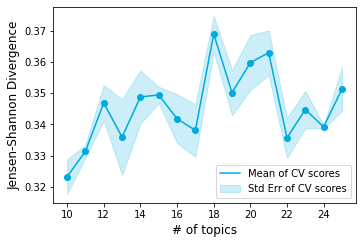

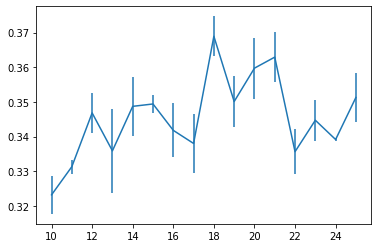

In [86]:
if __name__=='__main__':
    with open('../data/sklearn_model_cv_test.pkl', 'rb') as f:
        model = pickle.load(f)

ntopics_list = np.arange(10,26)

cvmean = model.cv_results_['mean_test_score']
cvstd = model.cv_results_['std_test_score']

fs = 12
fig = plt.figure(figsize=(6,4))
plt.plot(ntopics_list, cvmean, c='#00aadd')
cvse = cvstd/np.sqrt(10)
plt.fill_between(ntopics_list, cvmean+cvse, cvmean-cvse, alpha=.2, color='#00aadd')
plt.legend(['Mean of CV scores', 'Std Err of CV scores'], loc='lower right')
plt.scatter(ntopics_list, cvmean, c='#00aadd')
plt.xlabel('# of topics', fontsize=fs)
plt.ylabel('Jensen-Shannon Divergence',fontsize=fs)
plt.gcf().subplots_adjust(bottom=.2)
plt.gcf().subplots_adjust(left=.2)
plt.savefig('figures/lda_sklearn_cv.png')
plt.show()
plt.errorbar(ntopics_list, cvmean, yerr=cvse); plt.show()

In [87]:
# re-define model using optimal # of topics

# things to try: nouns and verbs, alpha and eta, increase # of passes (3-4 is normally good), ngrams

ntopics = 18
myseed = 1
pkg = 'sklearn'

if pkg == 'sklearn':
    lda_model = LDAwithCustomScore(random_state=myseed, n_components=ntopics, learning_decay=.7, doc_topic_prior=None, topic_word_prior=None)
    lda_model.fit_transform(X);
    data = pyldavis_sklearn.prepare(lda_model, X, countvec, mds = 'tsne', sort_topics=False, R=20)
elif pkg == 'gensim':
    lda_model =  gensim.models.LdaMulticore(bow_corpus, num_topics = ntopics, id2word = dictionary, 
                                        random_state=myseed, passes = 10, workers = 2) #iterations = 300
    data = pyldagensim.prepare(lda_model, bow_corpus, dictionary, mds='tsne', sort_topics=False, R=20)
    coherence_model_lda = CoherenceModel(model=lda_model, texts = processed_info, corpus=bow_corpus, dictionary=dictionary, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    
lda_model.score(X)

0.3625779776293428

In [88]:
# fix terms to be lemmatized most commonword instead of stemmed word
for row in range(len(data.topic_info.index)):
    if row%50 == 0:
        print(row)
    maxword = dict_stem_maxword[data.topic_info["Term"].iloc[row]]
    data.topic_info["Term"].iloc[row] = maxword

0
50
100
150
200
250
300
350
400
450
500


In [89]:
pyLDAvis.save_html(data,'../data/courseviz.html')
pyLDAvis.enable_notebook()
pyLDAvis.display(data)

In [90]:
# jaccard
topn = int(np.ceil(np.shape(X)[0]*(10/100)))
topic_word_probs = lda_model.components_
top_terms = np.argsort(-1*topic_word_probs,axis=1)
top_terms = top_terms[:,0:topn]
jdists = np.zeros((ntopics,ntopics))
for i in range(ntopics):
    for j in range(ntopics):  
        jdist = jaccard(top_terms[i,:], top_terms[j,:])
        jdists[i,j] = jdist

# jensen shannon distance
js_dists = np.zeros((ntopics,ntopics))
topic_dists = lda_model.components_
for i in range(ntopics):
    for j in range(ntopics):
        js_dists[i,j] = jensen_shannon(topic_dists[i,:], topic_dists[j,:])

Mean Jaccard distance: 0.9593360360950481
Mean JS distance: 0.5405502087237517


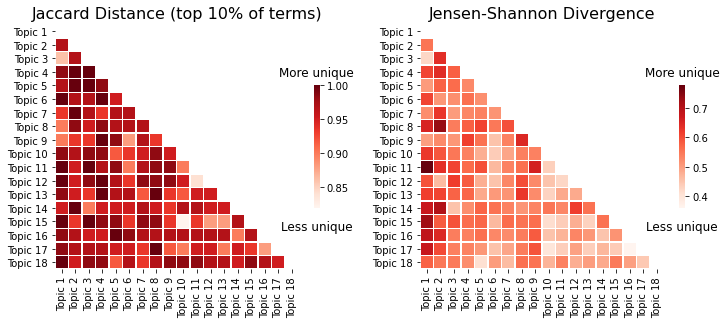

In [91]:
# plots

mask = np.zeros_like(jdists, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

uptri_jdists = np.triu(jdists)
uptri_jdists = uptri_jdists[uptri_jdists>0]
print('Mean Jaccard distance:', np.mean(uptri_jdists))


uptri_js_dists = np.triu(js_dists)
uptri_js_dists = uptri_js_dists[uptri_js_dists>0]
print('Mean JS distance:', np.mean(uptri_js_dists))


def label_cbar(ax):
    cb = ax.collections[0].colorbar
    cb.ax.text(0.5, -0.1, 'Less unique', transform=cb.ax.transAxes, 
        va='top', ha='center', fontsize=12)
    cb.ax.text(0.5, 1.05, 'More unique', transform=cb.ax.transAxes, 
        va='bottom', ha='center', fontsize=12)

fig = plt.figure(figsize=(12,5))

fig.add_subplot(121)
ax = sns.heatmap(jdists, mask=mask, cmap='Reds', vmin=np.round(np.min(uptri_jdists),2),
            linewidths=.5, cbar_kws={"shrink": .5})
tick_labels = ['Topic ' + str(topic) for topic in np.arange(ntopics)+1]
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_yticklabels(tick_labels, rotation=0)
label_cbar(ax)
plt.title('Jaccard Distance (top 10% of terms)',fontsize=16)

fig.add_subplot(122)
ax = sns.heatmap(js_dists, mask=mask, cmap='Reds', vmin=np.round(np.min(uptri_js_dists),2),
            linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_yticklabels(tick_labels, rotation=0)
label_cbar(ax)
plt.title('Jensen-Shannon Divergence', fontsize=16)

plt.gcf().subplots_adjust(bottom=.2)
plt.savefig('figures/topic_uniqueness.png')
plt.show()


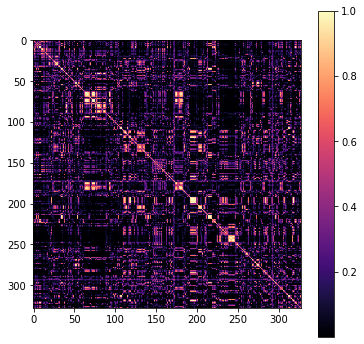

In [93]:
# similarity b/w topic scores 
    
scoremat = lda_model.transform(X)

scorecorrs = cos_sim(scoremat)

fig = plt.figure(figsize=(6,6))
plt.imshow(scorecorrs, cmap='magma')
plt.colorbar()
plt.show()

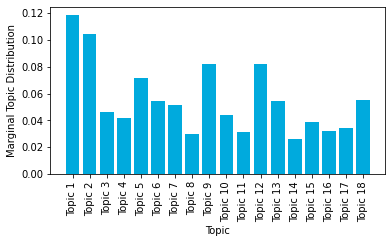

In [94]:
# distribution of best-matching topics

# this is how freqs are calculated in pyLDAvis code
doc_lengths = X.sum(axis=1).getA1()
doc_topic_dists = lda_model.transform(X)
topic_freq = np.dot(doc_topic_dists.T, doc_lengths) # (doc_topic_dists.T * doc_lengths).T.sum()
topic_proportion = (topic_freq / topic_freq.sum())

fig = plt.figure(figsize=(6,4))
plt.bar(np.arange(ntopics)+1, topic_proportion, color="#00aadd")
my_x_labels = []
for x in range(ntopics):
    my_x_labels.append('Topic ' + str(x+1))
plt.xticks(np.arange(ntopics)+1,my_x_labels, rotation=90)
#plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Marginal Topic Distribution')
plt.gcf().subplots_adjust(bottom=.3)
plt.savefig('figures/topicdist.png')
plt.show()

0.612138418215771
min strength: 2.0000000000000004


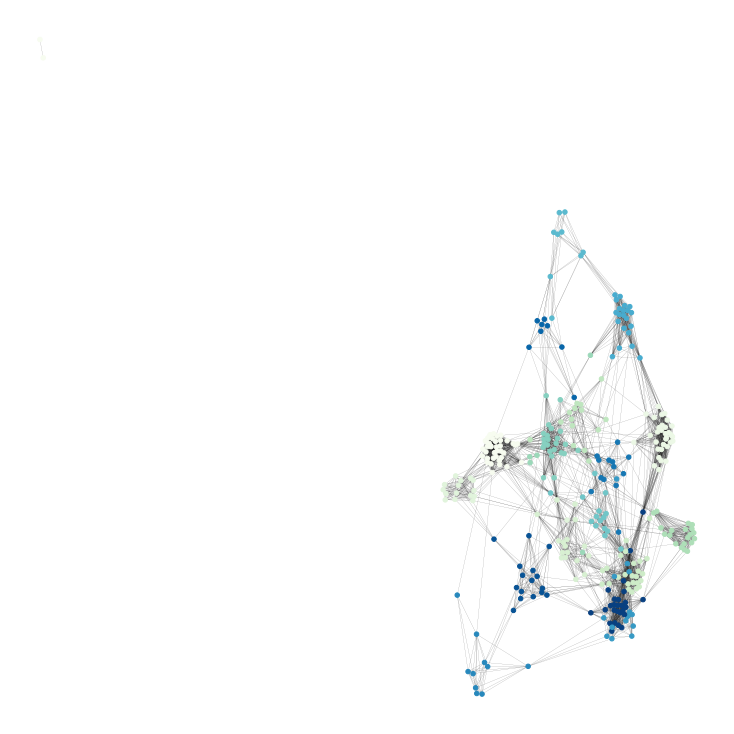

In [97]:
# graph theory with networkx

scorecorrs = cos_sim(scoremat)
scorecorrs_triu = np.triu(scorecorrs)
scorecorrs_triu = scorecorrs_triu[scorecorrs_triu>0]
thresh = np.percentile(scorecorrs_triu,92.5)
#thresh=.7
print(thresh)
scorecorrs[scorecorrs<=thresh] = 0

strength = np.sum(scorecorrs,0)
print('min strength:', np.min(strength))

G = nx.from_numpy_matrix(scorecorrs)
pos = nx.spring_layout(G)
weights = dict(G.degree(weight='weight'))
values = [weights.get(node, 0.25) for node in G.nodes()]
values_lda = copy.deepcopy(values)
values = np.argmax(doc_topic_dists,axis=1)

# file = open('../edu-app/course_titles.pkl','rb')
# titles_all = pickle.load(file)
# file.close()

# file = open('../edu-app/networkx_graph.pkl','wb')
# pickle.dump(G, file)
# file.close()

# file = open('../edu-app/networkx_pos.pkl', 'wb')
# pickle.dump(pos, file)
# file.close()

# file = open('../edu-app/networkx_values.pkl', 'wb')
# pickle.dump(values, file)
# file.close()

# with open('../edu-app/static/nodes_orig.csv', mode='w') as fp:
#     fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     fwriter.writerow(['x', 'y', 'strength', 'radius','title'])
#     for i in range(len(pos)):
#         fwriter.writerow([pos[i][0], pos[i][1], int(values[i]), 2, titles_all[i]])

plt.figure(1,figsize=(10,10)) 
nx.draw(G, pos, node_size=20, node_color = values, width=.1, cmap='GnBu', edge_color = "#222222")
plt.savefig("figures/jobs_lda_network.png", format="PNG")
plt.show(block=False)

# write edges.csv: saved edges are for visualization only (higher threshold)
# list_edges = list(G.edges())
# with open('../edu-app/static/edges_orig.csv', mode='w') as fp:
#     fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     fwriter.writerow(['x1', 'x2', 'y1', 'y2', 'width', 'color'])
#     for i in range(len(list_edges)):
#         if list_edges[i][0] != list_edges[i][1]:
#             x1 = pos[list_edges[i][0]][0]
#             x2 = pos[list_edges[i][1]][0]
#             y1 = pos[list_edges[i][0]][1]
#             y2 = pos[list_edges[i][1]][1]
#             fwriter.writerow([x1, x2, y1, y2, G.edges[list_edges[i][0],list_edges[i][1]]['weight'], '#000000'])